**[인공지능기초]** 기말과제 

---

**주제** : Finger Recognition

**목표** : 21600개의 왼손과 오른손 손가락 이미지를 학습하여, 왼손과 오른손을 구별하고 손가락을 셀 수 있는 모델을 설계한다.

**0) Importing Various Modules**

학습에 필요한 모듈들을 임포트 한다.

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras import regularizers

from skimage import io, transform, color

import os, glob

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import files

**1) Loading the Dataset**

Datasets 은 kaggle에서 다운받을 수 있다.

https://www.kaggle.com/koryakinp/fingers

여기서는 colab에서 바로 kaggle 사이트의 Dataset을 불러오는 방식을 사용하였다.

그러기 위해 kaggle.json파일을 업로드한다.

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


kaggle에서 Dataset를 받아 압축을 해제한 뒤, 해제된 csv 파일을 확인한다.

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d koryakinp/fingers
!unzip 'fingers.zip'
!ls

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/b912446e-1f0e-484b-a06a-81d775b4caf3_3L.png  
  inflating: train/b914ab2b-a181-487a-96bc-5e9186566a13_3R.png  
  inflating: train/b91591d8-cbf4-45e0-81ad-debdc3a7a781_1L.png  
  inflating: train/b917b1f5-8372-49b0-8601-d8244d736abb_1R.png  
  inflating: train/b920b98a-f844-4659-8d73-4610549fc3a2_3L.png  
  inflating: train/b920bff3-4ad0-4685-961d-5843a27af49a_5L.png  
  inflating: train/b92136e3-7b17-41e1-a20e-723cc4516df3_0R.png  
  inflating: train/b921a0bf-688b-424b-aea2-e42a72f84fd6_2L.png  
  inflating: train/b92367f8-c20a-4ca2-bf08-6e312e646f1f_0R.png  
  inflating: train/b924cf6c-2707-4384-a3db-3756abf739ed_0L.png  
  inflating: train/b92a7b32-0ea7-4c96-90f5-28e04ee6b8d9_5L.png  
  inflating: train/b9333c9e-4a78-46df-b961-d85dc101334f_1R.png  
  inflating: train/b93d052a-59e4-4570-b06a-42307eb8a61f_3R.png  
  inflating: train/b93eeaef-4760-474e-9911-6b8ae8e5aa8f_4L.png  
  inflating: train/b945af5c-e0f1-4855-bae3-50cbf7c4777

label은 파일 이름의 마지막 문자 2개로 구성되고, L/R은 왼손/오른손, 0,1,2,3,4,5는 손가락 수를 나타낸다.

또한 다음과 같이 초기 Dataset 자체가 Training set과 Test set으로 나누어져 있고, 모든 이미지는 128*128 픽셀 크기로 이루어져 있다.

- **Training set**: 18000 images
- **Test set**: 3600 images
- All images are 128 by 128 pixels.

따라서 각각의 Training set과 Test set을 미리 분리하여 불러온다.

In [ ]:
train_files = glob.glob("../content/train/*.png")
test_files = glob.glob("../content/fingers/test/*.png")

**2) Data Preprocessing**

Dataset을 이미지와 label부분으로 나누어 x_train, x_test, y_train, y_test에 list 형태로 저장한다. 


In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []

for img in train_files:
    img_read = io.imread(img)
    x_train.append(img_read)
    y_train.append(img[-6:-4])
    
for img in test_files:
    img_read = io.imread(img)
    x_test.append(img_read)
    y_test.append(img[-6:-4])

앞쪽에서부터 4번째까지의 이미지를 확인해 보면 다음과 같다.

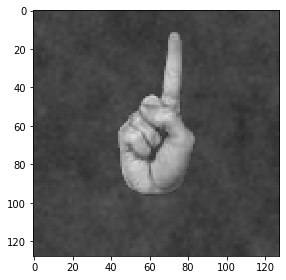

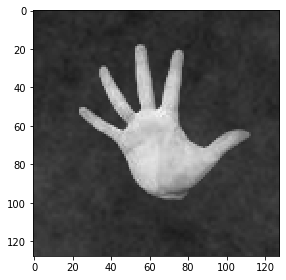

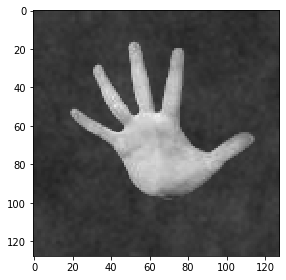

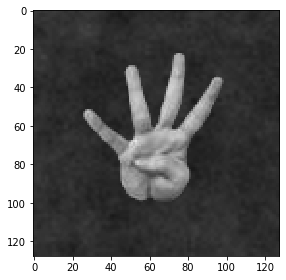

In [ ]:
io.imshow(x_train[0])
plt.show()
io.imshow(x_train[1])
plt.show()
io.imshow(x_train[2])
plt.show()
io.imshow(x_train[3])
plt.show()

label 또한 4번째까지 확인해보았다.

In [ ]:
y_train[:4]

['1R', '5R', '5R', '4R']

list형식으로 저장되어 있는 이미지를 array형식으로 변환한 뒤, 학습에 적용하기 위해 차원를 증가시킨다.

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape,x_test.shape)

(18000, 128, 128, 1) (3600, 128, 128, 1)


변환된 이미지를 스케일링 해준다.

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

마지막으로 label에 One hot encoding을 해준다.

In [ ]:
label_to_int={
    '0R' : 0,
    '1R' : 1,
    '2R' : 2,
    '3R' : 3,
    '4R' : 4,
    '5R' : 5,
    '0L' : 6,
    '1L' : 7,
    '2L' : 8,
    '3L' : 9,
    '4L' : 10,
    '5L' : 11
}

temp = []
for label in y_train:
    temp.append(label_to_int[label])
y_train = temp.copy()

temp = []
for label in y_test:
    temp.append(label_to_int[label])
y_test = temp.copy()
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 12)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 12)

**3) Model Definition**

결과값을 왼손과 오른손, 그리고 손가락의 개수로 분류하는 다중 분류 문제이기 때문에 활성함수로 'softmax'를 사용하여 모델을 정의하였다. 

In [ ]:
model = Sequential([
                    Conv2D(32, (3,3), activation = 'relu',input_shape = (128, 128, 1)),
                    MaxPooling2D(2,2),
                    Conv2D(32, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Conv2D(64, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Conv2D(64, (3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(12, activation = 'softmax')
])

정의된 모델은 다음과 같이 나타난다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        3

**4) Model Compile**

optimizer는 Adam, loss는 categorical cross entropy, 학습률은 0.01로 설정하여 모델을  컴파일하였다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])

**5) Model Learning**

batch_size=128, epochs=10 으로 설정하고 학습을 진행하였다.

In [ ]:
history = model.fit(x = x_train,y = y_train, batch_size=128, validation_data = (x_test,y_test), epochs = 10)

Epoch 1/10
141/141 [==============================] - 52s 56ms/step - loss: 1.7630 - accuracy: 0.5263 - val_loss: 0.0118 - val_accuracy: 0.9967
Epoch 2/10
141/141 [==============================] - 7s 47ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0136 - val_accuracy: 0.9950
Epoch 3/10
141/141 [==============================] - 7s 48ms/step - loss: 0.0101 - accuracy: 0.9963 - val_loss: 0.0123 - val_accuracy: 0.9961
Epoch 4/10
141/141 [==============================] - 7s 47ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 3.5631e-05 - val_accuracy: 1.0000
Epoch 5/10
141/141 [==============================] - 7s 47ms/step - loss: 4.8963e-05 - accuracy: 1.0000 - val_loss: 3.0807e-06 - val_accuracy: 1.0000
Epoch 6/10
141/141 [==============================] - 7s 47ms/step - loss: 4.4773e-06 - accuracy: 1.0000 - val_loss: 2.6281e-06 - val_accuracy: 1.0000
Epoch 7/10
141/141 [==============================] - 7s 47ms/step - loss: 2.1347e-06 - accuracy: 1.0000 - val_loss: 2.27

학습된 모델의 Training accuracy와  Validation accuracy, Training loss와 Validation loss를 각각 그래프로 비교해 보았다.

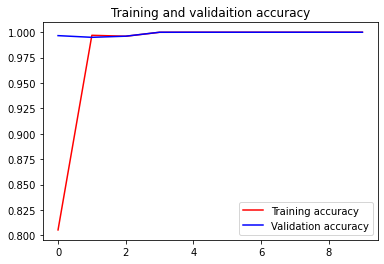

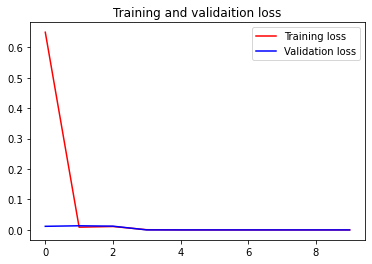

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r',label='Training accuracy')
plt.plot(epochs, val_acc, 'b',label='Validation accuracy')
plt.title('Training and validaition accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r',label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.title('Training and validaition loss')
plt.legend()

최종적으로 모델은 다음과 같은 loss와 accuracy  수치를 기록하였다.

In [ ]:
model.evaluate(x_test, y_test, verbose = 2 )

113/113 - 1s - loss: 8.1468e-06 - accuracy: 1.0000


[8.146825166477356e-06, 1.0]

**6) Prediction**

Test set에 대한 confusion matrix 와 classification report를 보고 모델 성능을 확인한다.  

In [ ]:
y_pred_test = model.predict_classes(x_test)
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[300   0   0   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0]
 [  0   0   0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300]]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       300
           1      1.000     1.000     1.000       300
           2      1.000     1.000     1.000       300
           3      1.000     1.000     1.000       300
           4      1.000     1.000     1.000       300
           5      1.000     1.000     1.000       300
           6      1.000     1.000     1.000       300
           7      1.000     1.000     1.000       300
           8      1.000     1.000     1.000       300
           9      1.000     1.000     1.000       300
          10      1.000     1.000     1.000       300
          11      1.000     1.000     1.000       300

    accuracy                          1.000      3600
   macro avg      1.000     1.000     1.000      3600
weighted avg      1.000     1.000     1.000      3600



마지막으로 실제 이미지 파일을 업로드하여 예측결과를 확인해 보았다.

Saving 9ed23c20-bf0d-4051-b6d8-8342d034248c_0L.png to 9ed23c20-bf0d-4051-b6d8-8342d034248c_0L.png


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


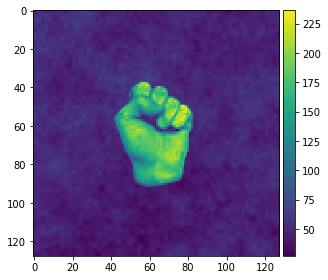

(1, 128, 128, 1)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9ed23c20-bf0d-4051-b6d8-8342d034248c_0L.png is a 0L


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/'+fn
  img = image.load_img(path, target_size=(128,128))
  x = image.img_to_array(img)
  x = color.rgb2gray(x)
  io.imshow(x)
  plt.show()
  x = np.expand_dims(x,axis=2)
  x = np.expand_dims(x,axis=0)
  images = np.vstack([x])
  print(images.shape)
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0][0]==1:
    print(fn + " is a 0R")
  elif classes[0][1]==1:
    print(fn + " is a 1R")
  elif classes[0][2]==1:
    print(fn + " is a 2R")
  elif classes[0][3]==1:
    print(fn + " is a 3R")
  elif classes[0][4]==1:
    print(fn + " is a 4R")
  elif classes[0][5]==1:
    print(fn + " is a 5R")
  elif classes[0][6]==1:
    print(fn + " is a 0L")
  elif classes[0][7]==1:
    print(fn + " is a 1L")
  elif classes[0][8]==1:
    print(fn + " is a 2L")
  elif classes[0][9]==1:
    print(fn + " is a 3L")
  elif classes[0][10]==1:
    print(fn + " is a 4L")
  elif classes[0][11]==1:
    print(fn + " is a 5L")

**결론** : 이 학습모델은 accuracy: 1.0000 이라는 좋은 학습결과를 얻었다. 이는 21600개의 충분한 데이터 때문이기도 하지만, 이미 잘 가공되어있는 데이터를 사용하여 학습을 진행했기 때문이라고 생각된다.